<a href="https://colab.research.google.com/github/GeeK1224/cau_ml_project/blob/main/cau_ml_project_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision.transforms import transforms
import torchvision

In [71]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [4]:
!wget https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_test_features_public.csv
!wget https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_train_data_public.csv
!wget https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/sample_submission.csv

--2023-12-17 15:22:46--  https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_test_features_public.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216168 (211K) [text/plain]
Saving to: ‘kaggle_test_features_public.csv’

kaggle_test_feature 100%[===================>] 211.10K  --.-KB/s    in 0.03s   

2023-12-17 15:22:46 (6.00 MB/s) - ‘kaggle_test_features_public.csv’ saved [216168/216168]

--2023-12-17 15:22:46--  https://raw.githubusercontent.com/GeeK1224/cau_ml_project/main/kaggle_train_data_public.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request 

## ml model team ATES

In [72]:
# Data Collection
test_data = pd.read_csv("kaggle_test_features_public.csv")
train_data = pd.read_csv("kaggle_train_data_public.csv")
sample = pd.read_csv("sample_submission.csv")

In [73]:
def one_hot_encode_column(dataframe, column_name):
    """
    Perform one-hot encoding on a specific column of a DataFrame.

    Parameters:
    - dataframe: pandas DataFrame
    - column_name: str, the name of the column to one-hot encode

    Returns:
    - dataframe_encoded: pandas DataFrame, the DataFrame with the specified column one-hot encoded
    """

    # Make a copy of the DataFrame to avoid modifying the original
    dataframe_copy = dataframe.copy()

    # Perform one-hot encoding
    dataframe_encoded = pd.get_dummies(dataframe_copy, columns=[column_name], prefix=column_name)

    return dataframe_encoded

In [74]:
def zeros_and_ones(dataframe, column_name):

  # Make a copy of the DataFrame to avoid modifying the original
  dataframe_copy = dataframe.copy()

  # Perform turning values to zeros and ones
  dataframe_copy[column_name].replace('Yes', 1, inplace=True)
  dataframe_copy[column_name].replace('No', 0, inplace=True)

  return dataframe_copy

In [75]:
# Feature engineering Test Data
drop_columns = ["CustomerID", "Count", "Country", "State", "City", "Zip Code", "Lat Long", "Latitude", "Longitude"]
category_yes_no = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
categories_many = ['Gender', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']

test_data = test_data.copy()
for category in category_yes_no:
  test_data = zeros_and_ones(test_data, category)


for category in categories_many:
  test_data = one_hot_encode_column(test_data, category)

encode_test = test_data.drop(drop_columns, axis=1)
encode_test


,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Gender_Female,Gender_Male,Multiple Lines_No,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,1,0,51,0,1,30.05,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,0,1,0,49,1,1,99.05,0,1,0,...,0,0,1,1,0,0,1,0,0,0
2,0,0,0,60,1,1,116.60,0,1,0,...,0,0,1,0,1,0,0,1,0,0
3,0,1,0,45,1,1,54.15,1,0,1,...,1,0,0,0,1,0,0,1,0,0
4,0,1,1,31,1,0,25.75,0,1,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0,1,0,34,1,0,62.65,1,0,0,...,1,0,0,1,0,0,0,0,1,0
982,0,0,1,9,1,0,55.35,0,1,1,...,1,0,0,1,0,0,0,0,1,0
983,1,1,0,23,1,1,95.10,1,0,1,...,0,0,1,1,0,0,0,0,1,0
984,0,0,0,21,1,1,99.15,1,0,1,...,0,0,1,1,0,0,1,0,0,0


In [76]:
# Feature engineering Train Data
drop_columns = ["CustomerID", "Count", "Country", "State", "City", "Zip Code", "Lat Long", "Latitude", "Longitude"]
category_yes_no = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
categories_many = ['Gender', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']

train_data = train_data.copy()
for category in category_yes_no:
  train_data = zeros_and_ones(train_data, category)


for category in categories_many:
  train_data = one_hot_encode_column(train_data, category)

encode_train = train_data.drop(drop_columns, axis=1)
encode_train

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Churn Score,Churn Value,CLTV,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,0,1,21,1,0,80.35,62,0,4579,...,1,0,0,1,0,0,0,0,1,0
1,0,0,1,9,1,0,93.00,40,0,2267,...,0,0,1,1,0,0,1,0,0,0
2,0,1,0,69,1,1,106.40,26,0,4328,...,0,0,1,0,1,0,0,1,0,0
3,0,0,0,9,1,1,75.85,70,0,5212,...,1,0,0,1,0,0,0,0,1,0
4,0,1,0,5,1,0,20.10,42,0,2894,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,0,0,0,3,1,0,55.35,65,1,5787,...,1,0,0,1,0,0,0,0,1,0
3940,0,1,0,24,1,1,93.00,29,0,5886,...,0,0,1,1,0,0,0,0,1,0
3941,0,0,0,1,1,1,45.70,95,1,2295,...,1,0,0,1,0,0,0,0,0,1
3942,1,1,0,47,1,1,67.45,67,0,4074,...,1,0,0,1,0,0,0,1,0,0


In [77]:
# deviding data to X and y
# Попробуйте с CLTV и без
targets = ['Churn Score', 'Churn Value' ,'CLTV', 'Churn Reason']

X = encode_train.drop(targets, axis=1)
y = encode_train['Churn Value']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# SMOTE

In [79]:
from imblearn.over_sampling import SMOTE

In [80]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [81]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class distribution before SMOTE:
0    1957
1     685
Name: Churn Value, dtype: int64

Class distribution after SMOTE:
1    1957
0    1957
Name: Churn Value, dtype: int64


# Models

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# XGBoost

In [ ]:
# Create an XGBoost classifier
model = XGBClassifier()

# Fit the model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
X_resampled_combined = np.concatenate((X_train_resampled, X_test), axis=0)
y_resampled_combined = np.concatenate((y_train_resampled, y_test), axis=0)

# Perform k-fold cross-validation (let's say k=5)
k = 5
cv_scores = cross_val_score(model, X_resampled_combined, y_resampled_combined, cv=k, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')

Cross-Validation Scores: [0.74239544 0.83745247 0.90969582 0.90494297 0.79657795]
Mean Accuracy: 0.8382


# Ensemble

In [46]:
# Model Class to be used for different ML algorithms
class ClassifierModel(object):
  def __init__(self, clf, params=None):
    self.clf = clf(**params)

  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)

  def fit(self,x,y):
    return self.clf.fit(x,y)

  def feature_importances(self,x,y):
    return self.clf.fit(x,y).feature_importances_

  def predict(self, x):
    return self.clf.predict(x)

  def predict_proba(self, x):
    return self.clf.predict_proba(x)


def trainModel(model, x_train, y_train, x_test, n_folds, seed):
  cv = KFold(n_splits=n_folds, random_state=seed, shuffle=True)
  scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
  return scores

In [47]:
# Random Forest parameters
rf_params = {
  'n_estimators': 400,
  'max_depth': 5,
  'min_samples_leaf': 3,
  'max_features' : 'sqrt',
}

rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores = trainModel(rfc_model, X_train_resampled, y_train_resampled, X_test, 5, 0)
rfc_scores

array([0.79948914, 0.85185185, 0.83908046, 0.80970626, 0.81585678])

In [48]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':400,
    'max_depth': 5,
    'min_samples_leaf': 2,
}
etc_model = ClassifierModel(clf=ExtraTreesClassifier, params=et_params)
etc_scores = trainModel(etc_model, X_train_resampled, y_train_resampled, X_test, 5, 0)
etc_scores

array([0.79054917, 0.85057471, 0.83141762, 0.80715198, 0.81457801])

In [49]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 400,
    'learning_rate' : 0.65
}
ada_model = ClassifierModel(clf=AdaBoostClassifier, params=ada_params)
ada_scores = trainModel(ada_model, X_train_resampled, y_train_resampled, X_test, 5, 0)
ada_scores

array([0.83908046, 0.88505747, 0.85568327, 0.84802043, 0.86061381])

In [50]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 400,
    'max_depth': 6,
}
gbc_model = ClassifierModel(clf=GradientBoostingClassifier, params=gb_params)
gbc_scores = trainModel(gbc_model, X_train_resampled, y_train_resampled, X_test, 5, 0)
gbc_scores

array([0.84546616, 0.87484036, 0.85568327, 0.84802043, 0.85038363])

In [54]:
rfc_train_pred = rfc_model.fit(X_train_resampled, y_train_resampled)
etc_train_pred = etc_model.fit(X_train_resampled, y_train_resampled)
ada_train_pred = ada_model.fit(X_train_resampled, y_train_resampled)
gbc_train_pred = gbc_model.fit(X_train_resampled, y_train_resampled)

etc_train_pred = etc_model.predict_proba(X_test)
rfc_train_pred = rfc_model.predict_proba(X_test)
ada_train_pred = ada_model.predict_proba(X_test)
gbc_train_pred = gbc_model.predict_proba(X_test)

x_train_ensamble = np.column_stack((etc_train_pred, rfc_train_pred, ada_train_pred, gbc_train_pred))

In [55]:
etc_train_pred = etc_model.predict_proba(encode_test)
rfc_train_pred = rfc_model.predict_proba(encode_test)
ada_train_pred = ada_model.predict_proba(encode_test)
gbc_train_pred = gbc_model.predict_proba(encode_test)

x_test_ensamble = np.column_stack((etc_train_pred, rfc_train_pred, ada_train_pred, gbc_train_pred))

In [56]:
from sklearn.metrics import mean_squared_error

In [58]:
# Вот у тебя есть прогон ансамбля всех данных а возьми и прогони оттуда данные а потом обучи линейную регрессию разпознавать наиболее точные данные
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(x_train_ensamble, y_test)

# Make predictions on the test set
y_pred = model.predict(x_test_ensamble)

In [62]:
ada_model.fit(x_train_ensamble, y_test)
y_pred = ada_model.predict_proba(x_test_ensamble)

In [63]:
y_pred.shape

(986, 2)

In [65]:
data_id_pred = {'ID': range(986), 'Churn Value': y_pred[:, 1]}

pred_data_csv = pd.DataFrame(data=data_id_pred)

compression_opts1 = dict(method='zip', archive_name='pred.csv')
pred_data_csv.to_csv('pred.zip', index=False, compression=compression_opts1)

In [ ]:
def trainStackModel(x_train, y_train, x_test, n_folds, seed):
  cv = KFold(n_splits= n_folds, random_state=seed, shuffle=True)
  gbm = XGBClassifier(
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1).fit(x_train, y_train)

  scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
  return scores

In [ ]:
stack_scores = trainStackModel(X_train_resampled, y_train_resampled, X_test, 5, 0)
stack_scores

array([0.84163474, 0.87994891, 0.85312899, 0.8403576 , 0.8516624 ])

# SVM

In [ ]:
svm_model = SVC()
svm_model = svm_model.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       942
           1       0.47      0.73      0.57       360

    accuracy                           0.70      1302
   macro avg       0.67      0.71      0.67      1302
weighted avg       0.76      0.70      0.71      1302



# TEST DATA

In [ ]:
ada_model.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(learning_rate=0.65, n_estimators=400)

In [ ]:
probabilities = svm_model.predict(encode_test)
probabilities

In [ ]:
data_id_pred = {'ID': range(986), 'Churn Value': probabilities}

pred_data_csv = pd.DataFrame(data=data_id_pred)

compression_opts1 = dict(method='zip', archive_name='pred.csv')
pred_data_csv.to_csv('pred.zip', index=False, compression=compression_opts1)

# Random Forest

In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train a Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Combine predictions using a Logistic Regression model (stacking)
stacked_X = np.column_stack((rf_predictions, gb_predictions))

stacking_model = LogisticRegression()
stacking_model.fit(stacked_X, y_test)

# Make individual predictions
rf_individual_preds = rf_model.predict(X_test)
gb_individual_preds = gb_model.predict(X_test)

# Combine individual predictions using stacking model
stacked_X_individual = np.column_stack((rf_individual_preds, gb_individual_preds))
ensemble_preds = stacking_model.predict(stacked_X_individual)

# Evaluate the performance of individual models
print(f'Random Forest Accuracy: {accuracy_score(y_test, rf_individual_preds):.4f}')
print(f'Gradient Boosting Accuracy: {accuracy_score(y_test, gb_individual_preds):.4f}')

# Evaluate the performance of the ensemble model
print(f'Ensemble Accuracy: {accuracy_score(y_test, ensemble_preds):.4f}')

Random Forest Accuracy: 0.7888
Gradient Boosting Accuracy: 0.8095
Ensemble Accuracy: 0.8095


In [ ]:
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

In [ ]:
X_resampled_combined = np.concatenate((X_train_resampled, X_test), axis=0)
y_resampled_combined = np.concatenate((y_train_resampled, y_test), axis=0)

# Perform k-fold cross-validation (let's say k=5)
k = 5
cv_scores = cross_val_score(model, X_resampled_combined, y_resampled_combined, cv=k, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')

Cross-Validation Scores: [0.77946768 0.83269962 0.90494297 0.90779468 0.77851711]
Mean Accuracy: 0.8407


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Display evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Logistic Regression

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LogisticRegression(random_state=42)

model.fit(X_train_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)

In [ ]:
X_combined = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y_combined = np.concatenate((y_train_resampled, y_test), axis=0)

# Perform k-fold cross-validation (let's say k=5)
k = 5
cv_scores = cross_val_score(model, X_combined, y_combined, cv=k, scoring='accuracy')

# Display cross-validation scores
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')

Cross-Validation Scores: [0.74904943 0.83460076 0.90779468 0.89638783 0.78612167]
Mean Accuracy: 0.8348


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Display evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Neural Network #1


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import random

In [ ]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 2: Define the neural network architecture
model = nn.Sequential(
    nn.Linear(40, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.Sigmoid(),
)

# Step 3: Choose a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = random.random()
    for inputs, labels in train_loader:
        model = GradientBoostingClassifier(base_estimator=model, n_estimators=50, learning_rate=0.1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy:.4f}')

print('Training finished')

TypeError: ignored

In [ ]:
import time

from IPython.display import clear_output

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
def subset_ind(dataset, ratio: float):
    ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [ ]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(40, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE

                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(### YOUR CODE HERE)
                y_pred = ### YOUR CODE HERE
                ep_val_accuracy.append(### YOUR CODE HERE)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Neural Network #2

In [88]:
import tensorflow as tf

In [89]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [90]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(40,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

32 nodes, dropout 0.2, lr 0.005, batch size 32


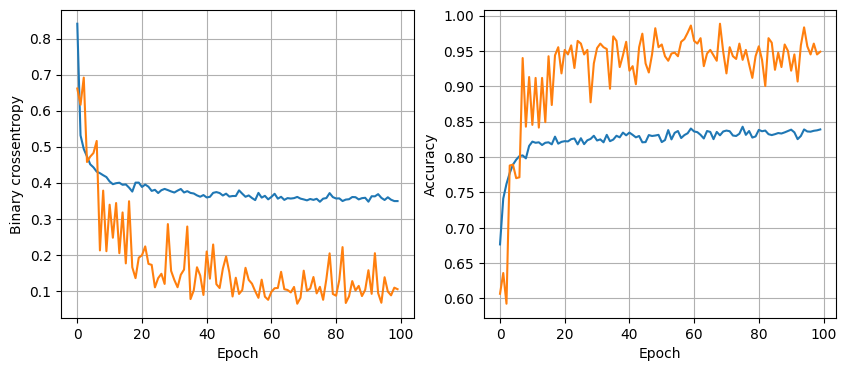

41/41 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.7949


In [92]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
num_nodes = 32
dropout_prob = 0.2
lr = 0.005
batch_size = 32

print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
model, history = train_model(X_train_resampled, y_train_resampled, num_nodes, dropout_prob, lr, batch_size, epochs)
plot_history(history)
val_loss = model.evaluate(X_test, y_test)[0]
if val_loss < least_val_loss:
  least_val_loss = val_loss
  least_loss_model = model

In [94]:
model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=100)

Epoch 1/100
123/123 [==============================] - 1s 5ms/step - loss: 0.3209 - accuracy: 0.8551
Epoch 2/100
123/123 [==============================] - 1s 6ms/step - loss: 0.3217 - accuracy: 0.8587
Epoch 3/100
123/123 [==============================] - 1s 6ms/step - loss: 0.3217 - accuracy: 0.8521
Epoch 4/100
123/123 [==============================] - 1s 5ms/step - loss: 0.3097 - accuracy: 0.8641
Epoch 5/100
123/123 [==============================] - 1s 4ms/step - loss: 0.3040 - accuracy: 0.8633
Epoch 6/100
123/123 [==============================] - 0s 4ms/step - loss: 0.3030 - accuracy: 0.8648
Epoch 7/100
123/123 [==============================] - 0s 3ms/step - loss: 0.3094 - accuracy: 0.8623
Epoch 8/100
123/123 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.8615
Epoch 9/100
123/123 [==============================] - 0s 3ms/step - loss: 0.3032 - accuracy: 0.8669
Epoch 10/100
123/123 [==============================] - 0s 3ms/step - loss: 0.3071 - accura

In [95]:
y_pred = model.predict(encode_test)

31/31 [==============================] - 0s 4ms/step


In [99]:
y_pred

array([[4.01328892e-01],
       [5.42506278e-01],
       [2.53364027e-01],
       [1.12964749e-01],
       [9.90610942e-03],
       [6.23725988e-02],
       [3.52040445e-03],
       [2.03118119e-02],
       [6.73904788e-06],
       [1.74500681e-02],
       [2.01308072e-01],
       [7.27495015e-01],
       [1.72838445e-05],
       [9.75841820e-01],
       [8.30287561e-02],
       [9.68882203e-01],
       [4.15019579e-02],
       [4.62983102e-01],
       [5.37568450e-01],
       [1.85211688e-01],
       [5.04540741e-01],
       [9.69341457e-01],
       [3.60300852e-04],
       [9.14856035e-04],
       [4.41877753e-01],
       [9.37172294e-01],
       [5.19598424e-01],
       [9.47863996e-01],
       [6.88742638e-01],
       [3.40446621e-01],
       [8.43381047e-01],
       [1.18145704e-01],
       [2.53798850e-02],
       [4.60829870e-06],
       [6.10240996e-01],
       [2.27707834e-03],
       [4.93255526e-01],
       [9.31720674e-01],
       [9.46593165e-01],
       [1.16154388e-01],


In [102]:
data_id_pred = {'ID': range(986), 'Churn Value': y_pred[:, 0]}

pred_data_csv = pd.DataFrame(data=data_id_pred)

compression_opts1 = dict(method='zip', archive_name='pred.csv')
pred_data_csv.to_csv('pred.zip', index=False, compression=compression_opts1)

In [ ]:
# Moddel Training

# Видео Ютуб

# NN

# initialize bias - посмотри как лучше начинать с нуля или с рандома

# SOFTPLUS | SIGMOID | ReLU | ARGMAX |

# GRADIENT BOOSTING

# DROPOUT

# Cross Entropy of 1 class = - log(output)
# Cross Entropy of 2 class = - log(output)
# Cross Entropy sum = class1 + class2
# backpropagation


# KFOLD

# BACKPROPAGATION
# MSE for squared residuals - sum of squared residuals end up being a curve
# then using Gradient Descent we finding optimal value for biased term

# SOFTMAX - for training, ARGMAX - for result


In [ ]:
# Model Evaluation
# AUC ROC

In [ ]:
# testing on test data

In [ ]:
# result